In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser


import sys
import scipy.interpolate as si
import os
import scipy.optimize

#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')
home = r'C:/Users/Kas/Documents/GitHub/'
sys.path.append(join(home,'helpfullscripts/'))
import forJCM
import geometry_2 as geo2
#import jcm_plotting_utils as JCMgrid

jcm_root = join(home,'JCMwave/JCMsuite_6_0_10/ThirdPartySupport/Python')
jcm_root = r'C:/Users/Kas/AppData/Roaming/JCMwave/JCMsuite/ThirdPartySupport/Python'
sys.path.append(jcm_root)
import jcmwave

sys.path.append(join(home,'XRR_workflows/calculate_n_k_from_xrr'))
import xray_compounds as xc
import pint
unit = pint.UnitRegistry()

import pickle 


In [6]:
#qnm,output_norm

def load_exp_data(name):
    exp_1 = pd.read_csv(name,delimiter=',')   
    exp_1_array = np.asarray(exp_1)    
    return exp_1_array

In [9]:
path = '.'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('V.csv') and f.startswith('')]
onlyfiles  

energy_list = [278.9, 284.5, 293.9, 400]
energy_list = np.asarray(energy_list)

exp_data_all = []

for i, entry in enumerate(energy_list):
    exp_data_temp = load_exp_data(onlyfiles[i])
    exp_data_all.append(exp_data_temp)

np.shape(exp_data_all[0])

(1122, 2)

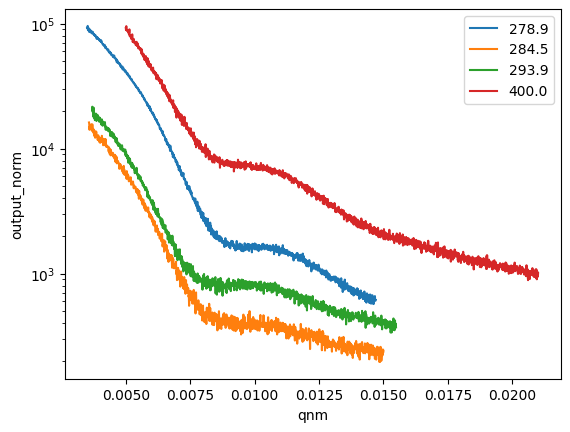

In [13]:
for i,entry in enumerate(exp_data_all):
    plt.plot(entry[:,0],entry[:,1],label=energy_list[i])
plt.xlabel('qnm')
plt.ylabel('output_norm')
plt.yscale('log')
plt.legend()

In [37]:
keys = forJCM.defkeys_680_v1()
keys['energy_list'] = energy_list
#keys['energy_list'] = np.array([278.9,284.5,293])
energy =  keys['energy_list'] * unit.eV
wl = energy.to(unit.nm, 'sp').magnitude
keys['energy'] = energy[-1].to(unit.keV, 'sp').magnitude
keys['pol'] = [0, 1] #1,0 s pol 0,1 p pol
keys['lambda'] = wl[-1] * 1e-9
keys['aoi_offset'] = 0
keys['phi_offset'] = 0

keys['scale'] = 1

nk_oleic_1 = np.conjugate(xc.refractive_index('C18H34O2', wl * unit.nm, density=2))
nk_oleic_2 = np.conjugate(xc.refractive_index('C18H34O2', wl * unit.nm, density=2))
nk_NaCl = np.conjugate(xc.refractive_index('NaCl', wl * unit.nm, density=2))

nk_oleic_1_all = pd.read_csv('oleic_dry_NEXAFS_optical_constant.csv')
#nk_NiO2_all = pd.read_excel('optical_const_for_Ni.xlsx',sheet_name=1)
f_n_oleic_1 = scipy.interpolate.interp1d(nk_oleic_1_all['Energy (eV)'],1-nk_oleic_1_all['delta'], kind='linear')
f_k_oleic_1 = scipy.interpolate.interp1d(nk_oleic_1_all['Energy (eV)'],nk_oleic_1_all['beta'], kind='linear')
#f_n_NiO2 = scipy.interpolate.interp1d(nk_NiO2_all['Energy (eV)'],1-nk_NiO2_all['delta'], kind='linear')
#f_k_NiO2 = scipy.interpolate.interp1d(nk_NiO2_all['Energy (eV)'],nk_NiO2_all['beta'], kind='linear')

nk_oleic_2_all = np.conjugate(xc.refractive_index('C18H34O2', np.asarray(nk_oleic_1_all['Energy (eV)']) * unit.eV, density=0.85))

nk_oleic_1 = []
#nk_NiO2 = []
for energy in keys['energy_list']:
    try:
      nk_oleic_1.append(f_n_oleic_1(energy)+f_k_oleic_1(energy)*1j)
    except:
      nk_oleic_1.append(np.conjugate(xc.refractive_index('C18H34O2', energy * unit.eV, density=0.85)))
#    nk_NiO2.append(f_n_NiO2(energy)+f_k_NiO2(energy)*1j)

keys['nk_oleic_1'] = nk_oleic_1
keys['nk_oleic_2'] = nk_oleic_2
keys['nk_NaCl'] = nk_NaCl

keys['nk'] = [1 + 0 * 1j, #vacuum
              nk_oleic_1[0], #oxide layer
              nk_oleic_2[0], #material of the grating
               nk_NaCl[0], #nk_Si3N4, #layer on top of the substrate
               1 + 0 * 1j #substrate nk_Si
             ]


keys['name_domain'] = ['vacuum','oleic_1','oleic_2','core','substrate']

keys_geo ={
    'radius_core':50,
    'radius_shell':100,
    'cd':50,
    'swa':85,
    'thickness_oxid_etch_offset':0,
    'thickness_oxid':3,
    'thickness_oxid_Si_Si3N4': 100,
    'height_offset_substrate':10,
    'height_offset_air':30,
    'R':3
    }

keys.update(keys_geo)
keys['width_cd'] = keys_geo['radius_shell']+10
keys['height_cd'] = keys_geo['radius_shell']*2+10
keys['MaximumSideLength'] = 1*keys['lambda']*1e9



Standard Keys for E=680eV


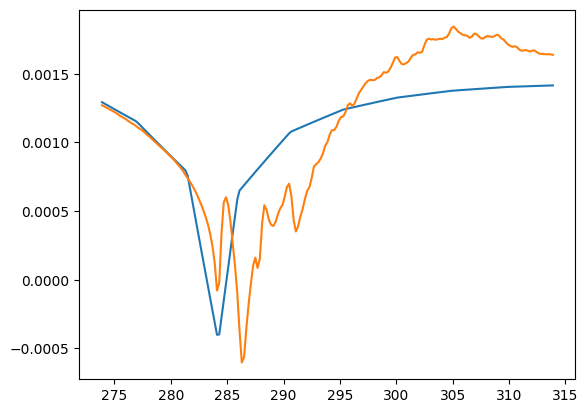

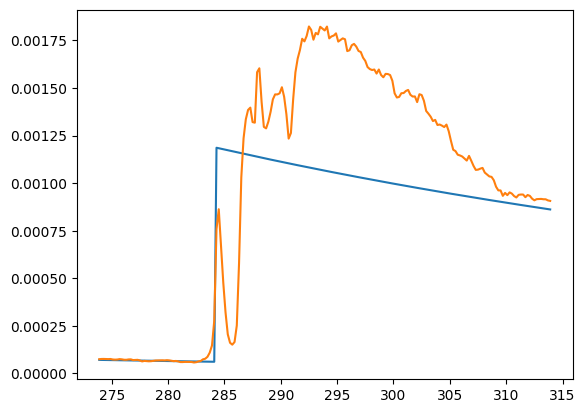

In [36]:

nk_oleic_2_all
plt.plot(nk_oleic_1_all['Energy (eV)'],1-np.real(nk_oleic_2_all))
plt.plot(nk_oleic_1_all['Energy (eV)'],nk_oleic_1_all['delta'])
plt.show()
plt.plot(nk_oleic_1_all['Energy (eV)'],np.imag(nk_oleic_2_all))
plt.plot(nk_oleic_1_all['Energy (eV)'],nk_oleic_1_all['beta'])

In [38]:
jcmwave.geo('./_JCMupdate/', keys=keys )
#figure,ax1 =plt.subplots(1,1, figsize=(5,10))
#JCMgrid.plot_grid('./_JCMupdate/grid.jcm', ax= ax1 , colors = {1: 'white', 2:'green', 3: 'black', 4:'orange', 5:'blue', 6:'green'}, alpha= 0.5 , lw = 0.2)
jcmwave.view('./_JCMupdate/grid.jcm')

In [43]:
keys['angle_of_incidence'] = 0 #+Theta_unique[30] #keys['angles'][10][0] #90-keys['angles'][0][0]+keys['aoi_offset'] +180
#print(Theta_unique[30])

keys['phi'] = 0 #90 +keys['angles'][0][1]+keys['phi_offset']  #
#keys['slc'] = 0.8
#keys['fem_deg'] = 4
        
#jcmwave.daemon.shutdown()
result = jcmwave.solve('./_JCMupdate/project.jcmpt',  keys=keys)




*** Solving c:\Users\Kas\Documents\Projects\nanosphere\_JCMupdate\project.jcmp on refinement level 0 ... 
  *** A priori interior domain wave propagation characteristics (vacuum wavelength = 3.100 nm):
  
       Compartment "X":
    computational domain size:   35 (wavelengths).
    computational domain range wave propagation error:    1
    'one wavelength' wave propagation error: 0.15 
  
       Compartment "Y":
    computational domain size:   68 (wavelengths).
    computational domain range wave propagation error:    1
    'one wavelength' wave propagation error: 0.17 
  
       Compartment "-Y":
    computational domain size:   68 (wavelengths).
    computational domain range wave propagation error:    1
    'one wavelength' wave propagation error: 0.18 

Cell percentage per Finite Element degree
  FEM degree  Cell percentage
-----------------------------------------
           3            100.0

*** Fourier mode 0:
assembling problem (190495 unknowns) ...  
nothing to do (zer

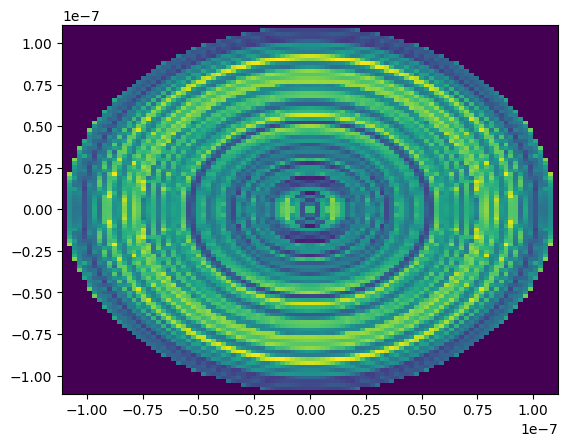

In [42]:
index_take = -1
amplitude = result[index_take]['field'][0]
intensity = (amplitude.conj()*amplitude).sum(2).real 

#intensity = np.absolute(result[4]['field'][0])
#np.shape(result[4]['X'])
np.shape(intensity)
#intensity
plt.pcolormesh(result[index_take]['X'],result[index_take]['Z'],intensity)

(709,)


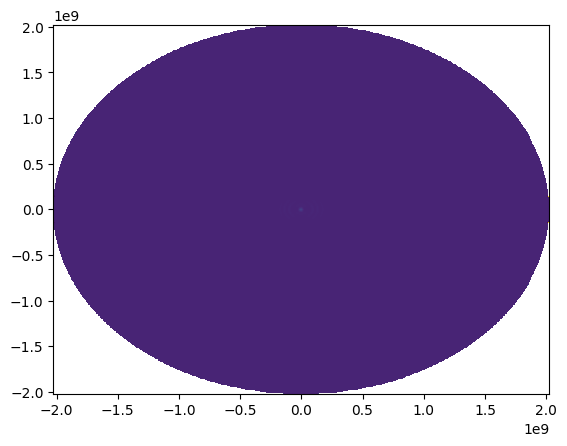

In [69]:

from scipy.interpolate import griddata
result[1].keys()#['K']
amplitude = result[1]['ElectricFieldStrength'][0]
amplitude
intensity = np.sum((amplitude.conj()*amplitude),axis=1)
np.shape(intensity)
np.shape(result[1]['K'])

x=result[1]['K'][:,0]
print(np.shape(np.unique(x)))
y =result[1]['K'][:,2]
z = intensity.real

grid_x, grid_y, grid_z = forJCM.interpolate_map(x,y,z)

plt.pcolormesh(grid_x, grid_y, grid_z)
#plt.pcolormesh(-grid_x, grid_y, grid_z)


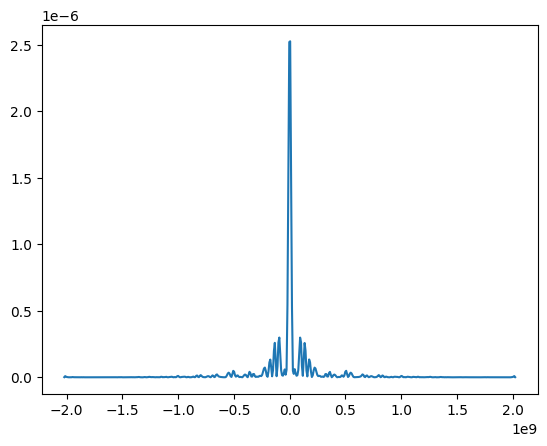

In [72]:
i_take = 250
plt.plot(grid_x[:,i_take],grid_z[:,i_take])
#np.shape(grid_x)